In [8]:
import pandas as pd

FILE = "INFLUD23-17-06-2024.csv"

INFLUD = pd.read_csv(FILE, sep=';')
POPULATION = pd.read_csv("StatePopulation.csv")
POPULATION.drop(columns=["STATE"], inplace=True)

In [9]:
import pickle
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, LabelEncoder

df = INFLUD.copy() 

# Filtra apenas os casos confirmados
df = df[df["CLASSI_FIN"].notna()]

# Agrupa por estado e data de notificação e conta o número de casos
df = df.groupby(["SG_UF_NOT", "DT_NOTIFIC"]).size().reset_index(name="CNT")

# Converte a data de notificação para o dia do ano
df["DOF_NOTIFIC"] = pd.to_datetime(df["DT_NOTIFIC"], format="%d/%m/%Y").dt.dayofyear
df.drop(columns="DT_NOTIFIC", inplace=True)


# Adiciona a população de cada estado
df = df.merge(POPULATION, left_on="SG_UF_NOT", right_on="UF")
df.drop(columns=["SG_UF_NOT"], inplace=True)

# Converte UF para numeral
uf_encoder = LabelEncoder()
df["UF"] = uf_encoder.fit_transform(df["UF"])
with open("encoders/uf.pickle", 'wb') as file:
    pickle.dump(uf_encoder, file, pickle.HIGHEST_PROTOCOL)

# risk_scaler = QuantileTransformer()
risk_scaler = MinMaxScaler()
df["RISK"] = df["CNT"] / df["POPULATION"]
df["RISK"] = risk_scaler.fit_transform(df[["RISK"]])

df.drop(columns=["CNT", "POPULATION"], inplace=True)

df

,DOF_NOTIFIC,UF,RISK
0,1,0,0.043576
1,32,0,0.109586
2,60,0,0.043576
3,91,0,0.109586
4,121,0,0.131589
...,...,...,...
9890,31,26,0.049226
9891,90,26,0.036812
9892,151,26,0.111298
9893,212,26,0.049226


In [20]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X = df[["DOF_NOTIFIC", "UF"]]
Y = df["RISK"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Modelo de Regressão Linear
linear_regression = LinearRegression()
linear_regression.fit(X_train, Y_train)

Y_pred = linear_regression.predict(X_test)

joblib.dump(linear_regression, "models/linear_regression.pkl")
linear_mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error (Linear Regression):", linear_mae)

# Modelo de Árvore de Decisão
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, Y_train)
joblib.dump(tree_model, 'modelDecisionTreeRegressor.joblib')

tree_Y_pred = tree_model.predict(X_test)

tree_mae = mean_absolute_error(Y_test, tree_Y_pred)
print("Mean Absolute Error (Decision Tree):", tree_mae)


# Modelo de Random Forest
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train, Y_train)
joblib.dump(forest_model, 'modelRandomForestRegressor.joblib')

forest_Y_pred = forest_model.predict(X_test)

forest_mae = mean_absolute_error(Y_test, forest_Y_pred)
print("Mean Absolute Error (Random Forest):", forest_mae)

Mean Absolute Error (Linear Regression): 0.05165227219032609
Mean Absolute Error (Decision Tree): 0.03759681895258062
Mean Absolute Error (Random Forest): 0.031971093313456704


In [11]:
date = pd.to_datetime("16/06/2024", format="%d/%m/%Y").dayofyear
uf = uf_encoder.transform(["SP"])[0]

y = linear_regression.predict([[date, uf]])
y

C:\Users\lucas.60022\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([0.05457491])

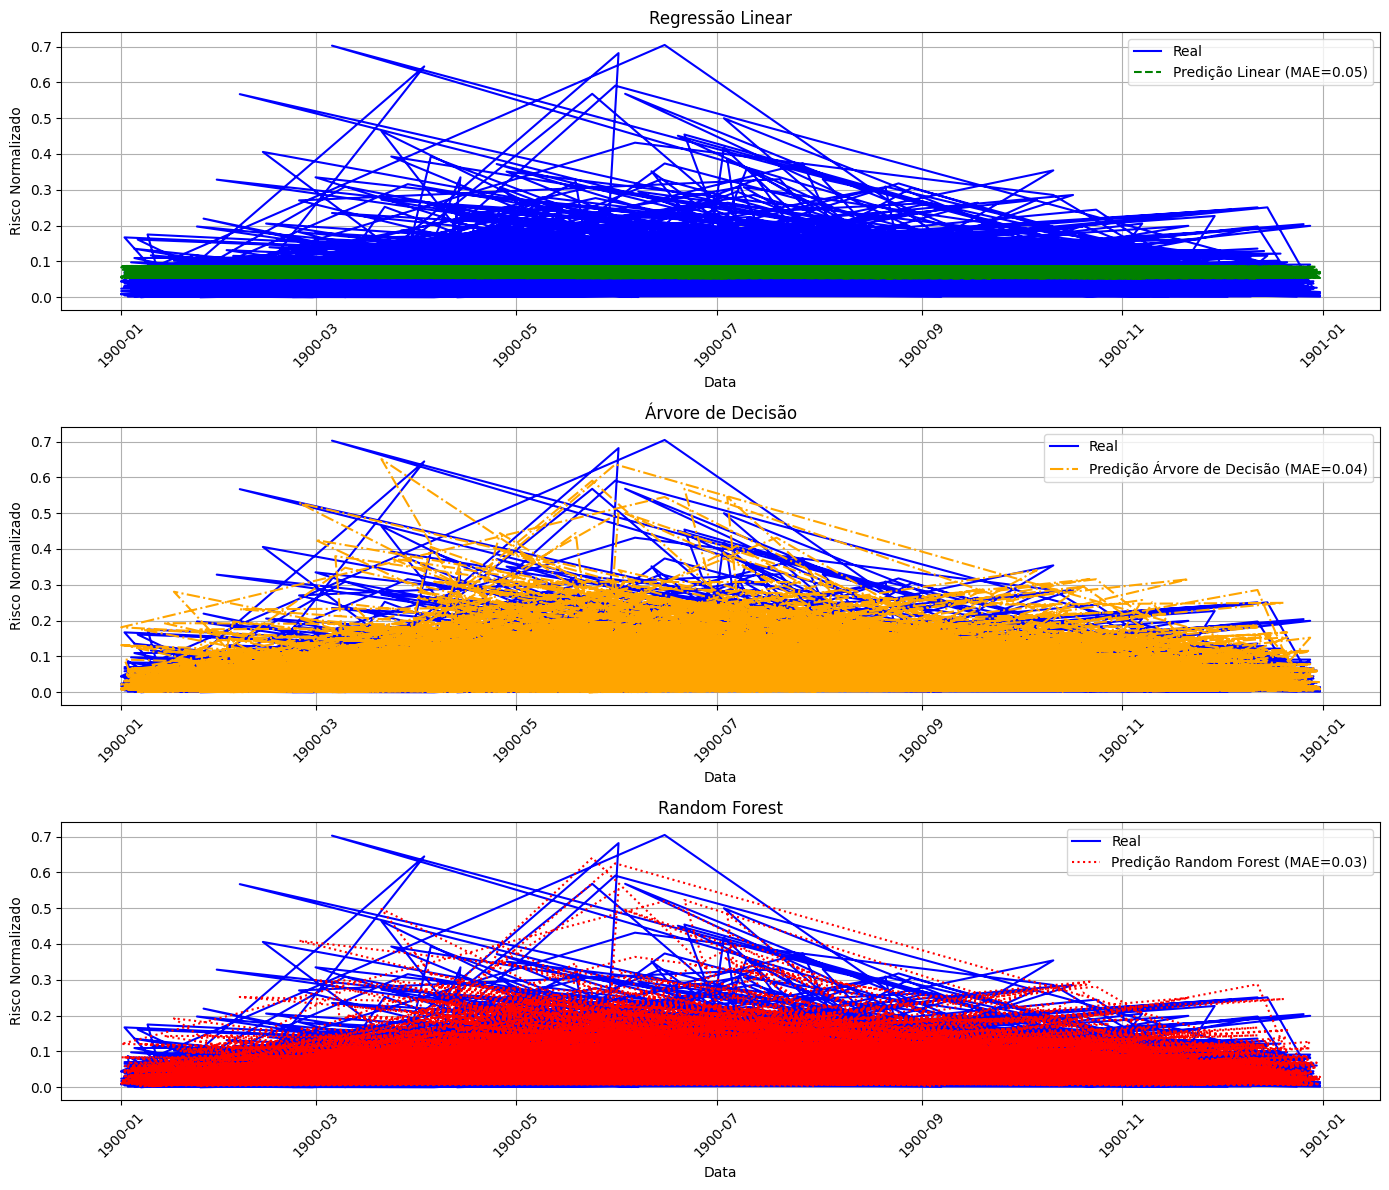

In [25]:
import matplotlib.pyplot as plt
# Converter DOF_NOTIFIC de dia do ano para data
df['DATA'] = pd.to_datetime(df['DOF_NOTIFIC'], format='%j').dt.date

# Criar gráfico de 3 linhas
plt.figure(figsize=(14, 12))

# Gráfico de Regressão Linear
plt.subplot(3, 1, 1)
plt.plot(df['DATA'].iloc[X_test.index], Y_test, label='Real', color='blue')
plt.plot(df['DATA'].iloc[X_test.index], Y_pred, label=f'Predição Linear (MAE={linear_mae:.2f})', linestyle='--', color='green')
plt.title('Regressão Linear')
plt.xlabel('Data')
plt.ylabel('Risco Normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Gráfico de Árvore de Decisão
plt.subplot(3, 1, 2)
plt.plot(df['DATA'].iloc[X_test.index], Y_test, label='Real', color='blue')
plt.plot(df['DATA'].iloc[X_test.index], tree_Y_pred, label=f'Predição Árvore de Decisão (MAE={tree_mae:.2f})', linestyle='-.', color='orange')
plt.title('Árvore de Decisão')
plt.xlabel('Data')
plt.ylabel('Risco Normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Gráfico de Random Forest
plt.subplot(3, 1, 3)
plt.plot(df['DATA'].iloc[X_test.index], Y_test, label='Real', color='blue')
plt.plot(df['DATA'].iloc[X_test.index], forest_Y_pred, label=f'Predição Random Forest (MAE={forest_mae:.2f})', linestyle=':', color='red')
plt.title('Random Forest')
plt.xlabel('Data')
plt.ylabel('Risco Normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
plt.show()